# Real estate price model 

Paul Waddell, Arezoo Besharati, July 2018

In [1]:
from __future__ import print_function
import warnings;warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

In [2]:
from scipy.stats import norm
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import os; os.chdir('../..')

In [4]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import OLSRegressionStep
import orca

In [5]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

## Explore the Orca registrations

In [6]:
orca.list_tables()

['parcels',
 'buildings',
 'craigslist',
 'rentals',
 'nodessmall',
 'nodeswalk',
 'units',
 'households',
 'persons',
 'jobs']

In [7]:
# for table_name in orca.list_tables():
#     print(table_name.upper())
#     print(orca.get_table(table_name).to_frame().columns.tolist())
#     print()

In [8]:
# plt.rcParams['figure.figsize']=8,8
# %matplotlib inline

# sns.set_style("white")
# sns.set_style("ticks")
# ax = sns.distplot(nodessmall.med_income_10000, bins=500,  fit=norm, kde=False)

# Estimate a price model

The basic idea of the parcel template is that we create model steps by _passing arguments to classes_ rather than by writing Python functions and giving them Orca decorators, as we would for a fully custom model.

Much of the functionality for this is already built into UrbanSim and Orca, we'll just need to extend things here and there.

This demo uses a new RegressionStep() class that provides a full model development workflow: estimating a model, registering it with Orca, saving it for future use.

## REPM Stimation for Single Family

In [9]:
m = OLSRegressionStep()
m.tables = ['buildings', 'parcels', 'nodeswalk', 'nodessmall']
m.filters = 'redfin_sale_year > 2010 & residential_units == 1 & sqft_per_unit > 50 & res_price_per_sqft < 2000'
m.model_expression = 'np.log1p(res_price_per_sqft) ~ + year_built + year_built > 2010 + \
    np.log(sqft_per_unit+1) + np.log(sqft_unit_500_walk+2)  + np.log(units_500_walk+1) + \
    np.log(avg_income_500_walk+1) + np.log(med_income_10000+1) + \
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) + \
    np.log(jobs_500_walk + 1) + np.log(jobs_25000 + 1) + np.log(pop_25000 + 1) +\
    np.log(pop_500_walk+1) + np.log(pop_black_500_walk+1) + np.log(pop_hisp_500_walk+1) + \
    np.log(pop_asian_500_walk+1)  '

m.out_transform = np.expm1


m.name = 'hedonic_price_sqft_single_family'
m.tags = ['REPM','SingleFamily']
m.fit()

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(res_price_per_sqft)   R-squared:                       0.394
Model:                                      OLS   Adj. R-squared:                  0.394
Method:                           Least Squares   F-statistic:                     3978.
Date:                          Mon, 23 Jul 2018   Prob (F-statistic):               0.00
Time:                                  15:37:30   Log-Likelihood:            -1.2295e+05
No. Observations:                        110137   AIC:                         2.459e+05
Df Residuals:                            110118   BIC:                         2.461e+05
Df Model:                                    18                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In [10]:
buildings = orca.get_table('buildings').to_frame()
buildings['predicted_price_sqft_sf'] = 0.0
orca.add_table('buildings', buildings)

m.out_filter = 'redfin_sale_year > 2010 & residential_units == 1 & sqft_per_unit > 50 & res_price_per_sqft < 2000'
m.out_column = 'predicted_price_sqft_sf'
m.run()

In [11]:
buildings['residuals_price_sqft_sf'] = buildings.predicted_price_sqft_sf - buildings.res_price_per_sqft
buildings[['res_price_per_sqft','predicted_price_sqft_sf','residuals_price_sqft_sf']].describe()

,res_price_per_sqft,predicted_price_sqft_sf,residuals_price_sqft_sf
count,1.824229e+06,1.824229e+06,1.824229e+06
mean,2.927191e+02,3.613195e+02,6.860033e+01
std,2.647712e+02,1.093858e+03,1.153024e+03
min,0.000000e+00,-1.000000e+00,-5.005435e+04
25%,1.518671e+02,0.000000e+00,-1.917030e+02
50%,2.544594e+02,2.060838e+02,-6.427851e+01
75%,3.699121e+02,3.292147e+02,2.766332e+01
max,5.016109e+04,8.132285e+04,8.132285e+04


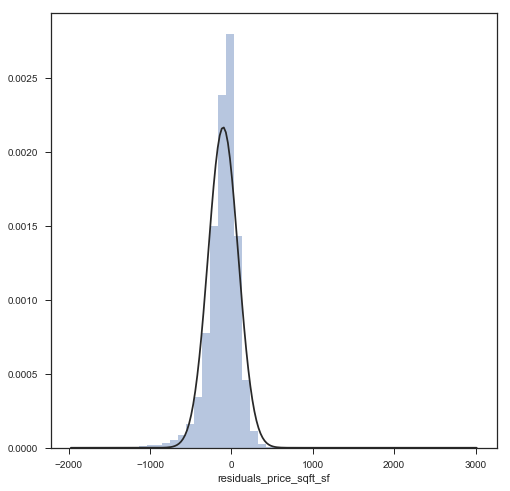

In [12]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
sns.set_style("white")
sns.set_style("ticks")
buildings_sf = buildings[(buildings['redfin_sale_year'] > 2010) & (buildings['residential_units'] == 1) & \
(buildings['sqft_per_unit'] > 50) & (buildings['res_price_per_sqft'] < 2000)]
ax = sns.distplot(buildings_sf.residuals_price_sqft_sf, fit=norm, kde=False)

(0, 2500)

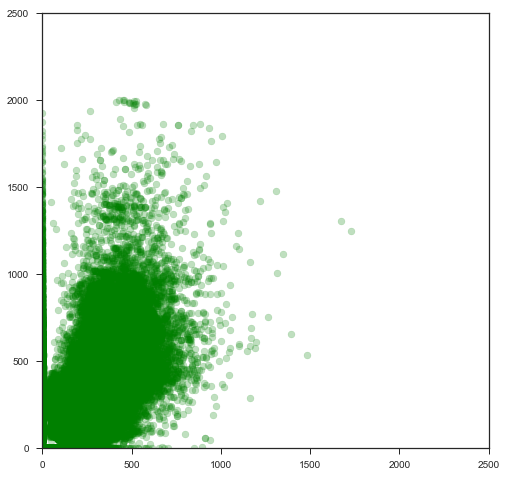

In [13]:
plt.scatter(buildings_sf['predicted_price_sqft_sf'], buildings_sf['res_price_per_sqft'],
                         c = "green", marker = "o", alpha=0.25)
plt.xlim(0, 2500)
plt.ylim(0, 2500)

In [14]:
m.register()

Please run 'mm.initialize()' before registering new model steps
Loading model step 'hedonic_price_sqft_single_family'


## REPM Stimation for Multi Family

In [15]:
mm.initialize()

Loading model step 'hedonic_price_sqft_multi_family'
Loading model step 'hedonic_price_sqft_single_family'
Loading model step 'hedonic_rent_sqft'
Loading model step 'hlcm'
Loading model step 'hlcm_multi_family'
Loading model step 'hlcm_multi_family1'
Loading model step 'hlcm_multi_family2'
Loading model step 'hlcm_multi_family3'


In [27]:
m2 = OLSRegressionStep()
m2.tables = ['buildings', 'parcels', 'nodeswalk', 'nodessmall']
m2.filters = 'redfin_sale_year > 2010 & residential_units > 1 & sqft_per_unit > 50 & 0<res_price_per_sqft < 2500'
m2.model_expression = 'np.log1p(res_price_per_sqft) ~ + year_built + year_built > 2010 + \
    np.log(sqft_per_unit+1) + np.log(sqft_unit_500_walk+2)  + np.log(units_500_walk+1) + \
    np.log(avg_income_500_walk+1) + np.log(med_income_10000+1) + \
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) +\
    np.log(jobs_500_walk + 1) + np.log(jobs_25000 + 1) + np.log(pop_25000 + 1) +\
    np.log(pop_500_walk+1) + np.log(pop_black_500_walk+1) + np.log(pop_hisp_500_walk+1) + \
    np.log(pop_asian_500_walk+1)  '

m2.out_transform = np.expm1

m2.name = 'hedonic_price_sqft_multi_family'
m2.tags = ['paul', 'version 1']
m2.fit()


                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(res_price_per_sqft)   R-squared:                       0.369
Model:                                      OLS   Adj. R-squared:                  0.368
Method:                           Least Squares   F-statistic:                     722.7
Date:                          Mon, 23 Jul 2018   Prob (F-statistic):               0.00
Time:                                  15:44:27   Log-Likelihood:                -21876.
No. Observations:                         22277   AIC:                         4.379e+04
Df Residuals:                             22258   BIC:                         4.394e+04
Df Model:                                    18                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In [17]:
m2.register()

Saving 'hedonic_price_sqft_multi_family.yaml': /Users/arezoobzadeh/Documents/GitHub/urbansim_parcel_bayarea/configs
Loading model step 'hedonic_price_sqft_multi_family'


In [28]:
buildings = orca.get_table('buildings').to_frame()
buildings['predicted_price_sqft_mf'] = 0.0
orca.add_table('buildings', buildings)
m2.out_column = 'predicted_price_sqft_mf'
m2.out_filter = 'redfin_sale_year > 2010 & residential_units > 1 & sqft_per_unit > 50 & 0< res_price_per_sqft < 2500'
m2.run()

In [30]:
buildings_mf = buildings[(buildings['redfin_sale_year'] > 2010) & (buildings['residential_units'] > 1) & \
(buildings['sqft_per_unit'] > 50) & (buildings['res_price_per_sqft'] < 2500)]

buildings_mf['residuals_price_sqft_mf'] = buildings_mf.predicted_price_sqft_mf - buildings_mf.res_price_per_sqft
buildings_mf[['res_price_per_sqft','predicted_price_sqft_mf','residuals_price_sqft_mf']].describe()

,res_price_per_sqft,predicted_price_sqft_mf,residuals_price_sqft_mf
count,28915.000000,28915.000000,28915.000000
mean,332.750828,229.906344,-102.844484
std,284.957617,185.719293,231.172517
min,0.000000,-0.660318,-2394.784802
25%,156.589951,104.731291,-197.891086
50%,255.515027,215.082414,-66.710969
75%,405.996512,330.549364,40.767875
max,2499.453679,1926.068965,1425.425201


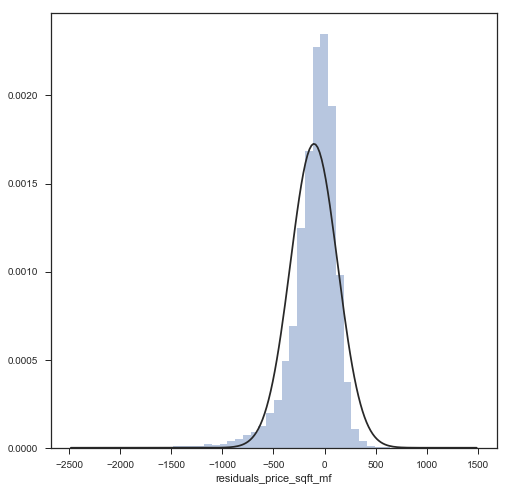

In [20]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
#plot(residuals.mean(),0, residuals.mean(), 2.25)
sns.set_style("white")
sns.set_style("ticks")
buildings_mf = buildings[(buildings['redfin_sale_year'] > 2010) & (buildings['residential_units'] > 1) & \
(buildings['sqft_per_unit'] > 50) & (buildings['res_price_per_sqft'] < 2500)]
ax = sns.distplot(buildings_mf.residuals_price_sqft_mf, fit=norm, kde=False)

(0, 2500)

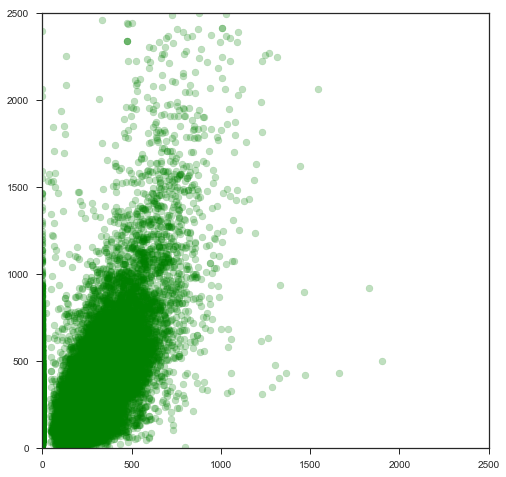

In [21]:
plt.scatter(buildings_mf['predicted_price_sqft_mf'], buildings_mf['res_price_per_sqft'],
                         c = "green", marker = "o", alpha=0.25)
plt.xlim(0, 2500)
plt.ylim(0, 2500)